In [ ]:
!pip install japanize-matplotlib
import japanize_matplotlib

# 基礎例題1: 映画レビューの二値分類("positive" or "negative")
とりあえずデータ作成

In [ ]:
import pandas as pd
from pathlib import Path

# ダミーデータ作成
data = {
    "review": [
        "The movie was fantastic! I really enjoyed it.",
        "Worst movie ever. I wasted two hours of my life.",
        "It was an okay film. Not great, but not terrible.",
        "Absolutely loved it! The best movie this year.",
        "Horrible acting and terrible plot. Do not recommend.",
        "A very touching story with excellent performances.",
        "The film was boring and way too long.",
        "Incredible cinematography and gripping story.",
        "Mediocre at best. I wouldn’t watch it again.",
        "Superb direction and great soundtrack. A must-watch!"
    ],
    "label": [1, 0, 1, 1, 0, 1, 0, 1, 0, 1]  # 1=Positive, 0=Negative
}

# データフレーム作成
df = pd.DataFrame(data)

# データフォルダ設定
data_dir = Path('/content/drive/MyDrive/Colab Notebooks/data')

# CSVとして保存
df.to_csv(data_dir / "movie_reviews.csv", index=False)
print("CSVファイルが作成されました。")

CSVファイルが作成されました。


## 本題の前に: 単語ベクトル化手法1
### TF-IDF(Term Frequency-Inverse Document Frequency)

  - TF: ある文書のなかに特定の単語がどれくらい登場するか--->目的の文書内での頻度
    - 文書1:「This is a great movie. The acting was fantastic.」
    - 文書2:「The movie was terrible. I will not recommend it.」
    - (文章1) movieの出現回数 = 1、文の全単語数 = 10、TF_1(movie) = 1 / 10
    - (文章2) movieの出現回数 = 1、文の全単語数 = 9、TF_2(movie) = 1 / 9

  - IDF: 特定の単語がすべての文書でどれくらい珍しいか--->文書間でのレア度
    - N: 文書の総数
    - d_t :単語tを含む文書数
    - IDF(t) = log(N/(1+d_t))
	- 「movie」は両方の文書に登場 →  IDF_1(movie) = log(2/(1+2)) ≒ -0.18
  - TF-IDF(t) = TF(t) \* IDF(t)
  - TF-IDF_1(movie) = 0.1 \* (-0.18) = -0.018
  - TF-IDF_2(movie) =  1 / 9 \* (-0.18) = -0.02


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# サンプルデータ
df = pd.read_csv(data_dir / "movie_reviews.csv")
documents = df['review'].tolist()[:3]

# TF-IDFベクトル化
vectorizer = TfidfVectorizer(stop_words='english') # stop_words='english'：the, he, in, is, and など英語の一般的なストップワードが自動的に削除されます。
X = vectorizer.fit_transform(documents)

# 結果を確認
print(vectorizer.get_feature_names_out())
print(X.toarray())

['enjoyed' 'fantastic' 'film' 'great' 'hours' 'life' 'movie' 'okay'
 'really' 'terrible' 'wasted' 'worst']
[[0.52863461 0.52863461 0.         0.         0.         0.
  0.40204024 0.         0.52863461 0.         0.         0.        ]
 [0.         0.         0.         0.         0.46735098 0.46735098
  0.35543247 0.         0.         0.         0.46735098 0.46735098]
 [0.         0.         0.5        0.5        0.         0.
  0.         0.5        0.         0.5        0.         0.        ]]


## 単語ベクトル化手法2
同じデータに対して今度はHuggingfaceからDistilBERTのトークナイザとエンコーダーを通じて埋め込みベクトルを得る

In [ ]:
from transformers import AutoTokenizer, AutoModel
import torch
import numpy as np

# トークナイザとエンコーダーのロード
model_checkpoint = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint) #  uncased: 「大文字と小文字を区別しない」
encoder = AutoModel.from_pretrained(model_checkpoint)

# エンコーダーをフリーズ
encoder.eval()

# テキスト達から埋め込みを得る関数
def get_bert_embeddings(texts):
    inputs = tokenizer(texts, padding=True, truncation=True, return_tensors="pt", max_length=512) # paddingは短い場合に0埋めし固定長にする, truncationは、最大長を超えた場合に切り取り固定長にする。
    # print(f'{inputs=}')
    with torch.no_grad():
        outputs = encoder(**inputs) # outputs.shape = (バッチサイズ, シーケンス長, 各トークンの埋め込み次元)
    return outputs.last_hidden_state[:, 0, :].numpy() # シーケンスの0番目が[CLS] token


embeddings = get_bert_embeddings(documents)
print(embeddings)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


[[ 0.13472511 -0.11771121  0.0577209  ... -0.07493205  0.39057425
   0.20153597]
 [ 0.0647999   0.00674988  0.04209154 ... -0.10047173  0.4034708
   0.1662673 ]
 [ 0.04829551 -0.16958712  0.05162412 ... -0.09341446  0.4102798
   0.2630738 ]]


## 本題: 映画レビューの二値分類("positive" or "negative")
コードの説明
- module load
- CSVデータロード
- train, testに分ける
- DistilBERTによる埋め込みの生成
- ロジスティック回帰で分類器を構築
- 予測と評価
- 混同行列の可視化

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.50      0.67         2
           1       0.50      1.00      0.67         1

    accuracy                           0.67         3
   macro avg       0.75      0.75      0.67         3
weighted avg       0.83      0.67      0.67         3



Text(0.5, 1.0, 'Confusion Matrix')

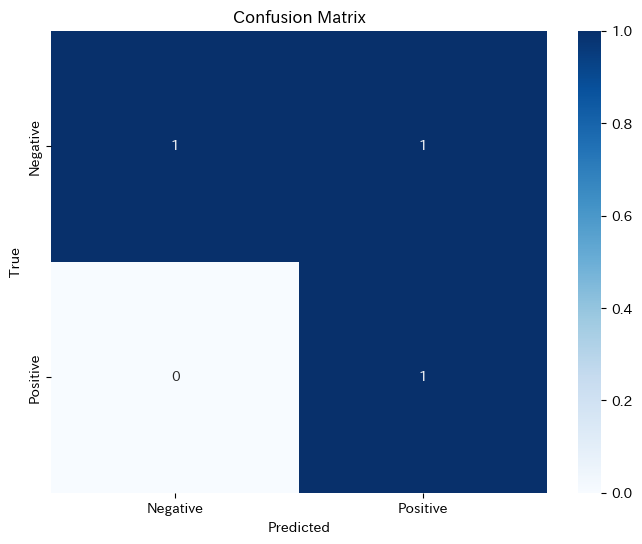

In [ ]:
# module load
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# CSVファイルの読み込み
df = pd.read_csv( data_dir / "movie_reviews.csv")
# print(f'{df.head(3)}')

# データ分割
X_train, X_test, y_train, y_test = train_test_split(df['review'], df['label'], test_size=0.3, random_state=0)

# 埋め込みの生成
X_train_embeddings = get_bert_embeddings(X_train.tolist()) # df -> python list
X_test_embeddings = get_bert_embeddings(X_test.tolist())

# ロジスティック回帰で分類器を構築
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train_embeddings, y_train)

# 予測と評価
y_pred = clf.predict(X_test_embeddings)
print("Classification Report:\n", classification_report(y_test, y_pred))

# 混同行列の可視化
conf_mat = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')

# 基礎例題2: 単語の共起ネットワーク作成
ニュース記事やレビューのテキストから、単語の共起ネットワークを作成し、頻出する単語の関係を可視化します。

In [ ]:
import pandas as pd

# ダミーデータの作成
data = {
    "article": [
        "The economy is recovering after the pandemic.",
        "The pandemic affected the global economy significantly.",
        "Technology companies are driving the economic recovery.",
        "Healthcare improvements are crucial after the pandemic.",
        "Global technology advances accelerate economic growth."
    ]
}

# CSVとして保存
df = pd.DataFrame(data)
df.to_csv(data_dir / "news_articles.csv", index=False)
print("ニュース記事データが作成されました。")

ニュース記事データが作成されました。


- コードの説明
  -	CountVectorizer を使って単語の出現回数をカウントします。
  -	単語同士の共起行列を作成し、NetworkXでネットワークとして可視化します。
  -	共起関係がある単語のみをエッジとして描画します。

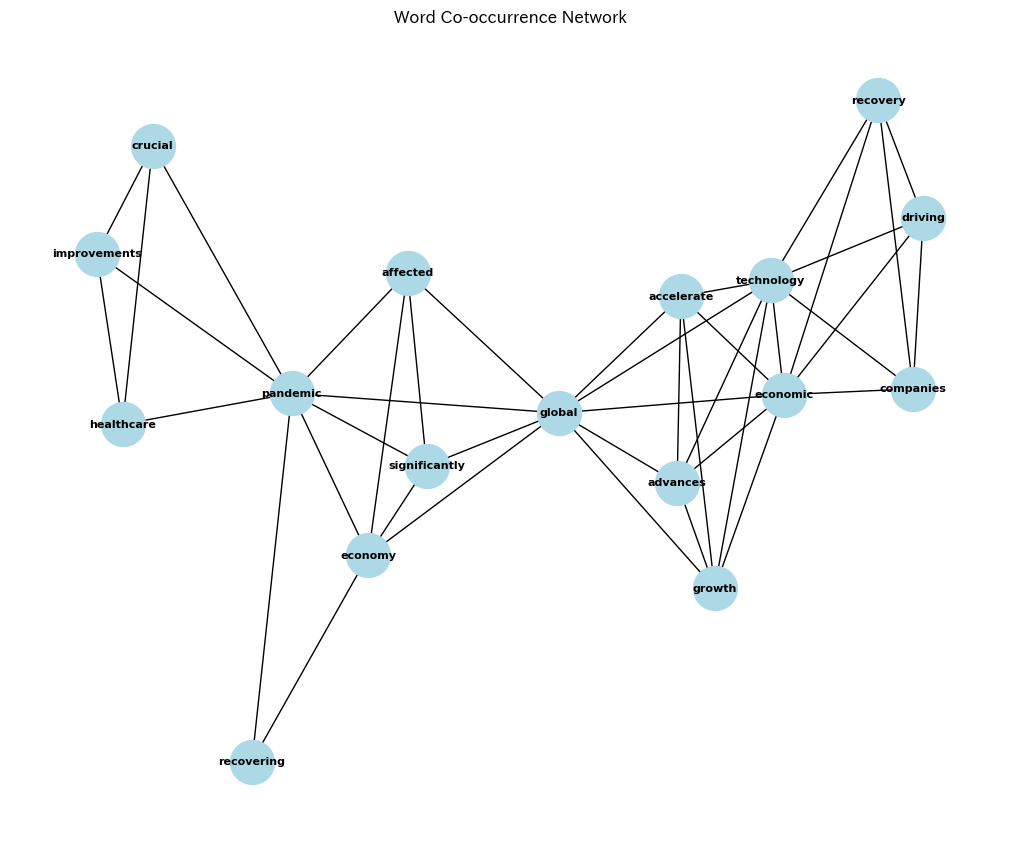

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
import networkx as nx
import matplotlib.pyplot as plt

# データ読み込み
df = pd.read_csv( data_dir / "news_articles.csv")

# 1. テキストのベクトル化（CountVectorizerで単語カウント）
vectorizer = CountVectorizer(stop_words='english')
X = vectorizer.fit_transform(df['article'])
# print(f'{X.shape}')  # (5, 17)

# 2. 共起行列を作成
cooccurance_matrix = (X.T @ X) # (17, 17) の共起行列
cooccurance_matrix.setdiag(0) # 対角成分は０にして自己共起を防ぐ

# 3. 単語リストを取得
words = vectorizer.get_feature_names_out()

# 4. networkxでグラフネットワークを初期化
G = nx.Graph()

# 5. ノードとエッジを追加
for i in range(len(words)):
    for j in range(i+1, len(words)):
        if cooccurance_matrix[i, j] > 0:
            G.add_edge(words[i], words[j], weight=cooccurance_matrix[i, j])

# 6. ネットワークの可視化
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(G, seed=0)
nx.draw(G, pos, with_labels=True, node_size=1000, node_color="lightblue", font_size=8, font_weight="bold")
plt.title("Word Co-occurrence Network")
plt.show()

# 基礎例題3: 文書の類似度計算
複数の製品レビューや記事の類似度を計算し、類似度の高い文書のペアを抽出します。

In [ ]:
data = {
    "review": [
        "The laptop has excellent battery life and a sleek design.",
        "This smartphone features a long-lasting battery and a stunning display.",
        "The tablet offers great performance but the battery is average.",
        "Battery life is poor, but the design is very modern.",
        "I love the camera and display, but the battery drains quickly."
    ]
}

df = pd.DataFrame(data)
df.to_csv(data_dir / "product_reviews.csv", index=False)
print("レビューのデータが作成されました。")

レビューのデータが作成されました。


In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

# 1. 以前作った関数でレビューを埋め込みに変換
embeddings = get_bert_embeddings(df['review'].tolist())

# 2. コサイン類似度の計算
similarity_matrix = cosine_similarity(embeddings)
# print(f'{similarity_matrix=}')

# 3. 類似度の高いペアを抽出
pairs = []
# 上三角行列のインデックスを取得 (対角成分を除く)
i, j = np.triu_indices(similarity_matrix.shape[0], k=1)

# ペアとスコアを取得
pairs = np.array(list(zip(i, j, similarity_matrix[i, j])))

# 類似度でソート
pairs = pairs[pairs[:, 2].argsort()[::-1]]  # 2列目（類似度）で降順ソート

# 5. 上位のレビューを表示
for idx1, idx2, score in pairs[:3]:
    print(f"Pair idx: {idx1} <-> {idx2}, Similarity: {score}")
    print(f"Review 1: {df['review'][idx1]}")
    print(f"Review 2: {df['review'][idx2]}")
    print("-" * 50)

Pair idx: 0.0 <-> 1.0, Similarity: 0.9837228059768677
Review 1: The laptop has excellent battery life and a sleek design.
Review 2: This smartphone features a long-lasting battery and a stunning display.
--------------------------------------------------
Pair idx: 0.0 <-> 2.0, Similarity: 0.9655783176422119
Review 1: The laptop has excellent battery life and a sleek design.
Review 2: The tablet offers great performance but the battery is average.
--------------------------------------------------
Pair idx: 2.0 <-> 3.0, Similarity: 0.9642763137817383
Review 1: The tablet offers great performance but the battery is average.
Review 2: Battery life is poor, but the design is very modern.
--------------------------------------------------


In [ ]:
csv_data = """review_id,product_name,rating,review,sentiment
1,Laptop,5,"This laptop is fantastic! Great performance.",positive
2,Smartphone,3,"Battery life is average but the design is sleek.",neutral
3,Tablet,1,"",negative
4,Laptop,4,"Good value for money. The display is sharp.",positive
5,Smartphone,2,"Camera quality is disappointing.",negative
6,Tablet,5,"Excellent tablet with long battery life.",positive
7,Laptop,,,positive
8,Smartphone,4,,neutral
9,Tablet,,,
10,Laptop,1,"Extremely slow and overheats often.",negative
"""

# ファイルとして保存
with open(data_dir / "product_reviews_nlp.csv", "w") as file:
    file.write(csv_data)

In [ ]:
import string
from nltk.corpus import stopwords
import nltk
from collections import Counter

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# 1. CSVデータの読み込み
df = pd.read_csv(data_dir / "product_reviews_nlp.csv")

# 2. 欠損値の確認
print("欠損値の件数:\n", df.isnull().sum())

# 3. 欠損値処理

## (1) review列の欠損を「No review provided」で補完
df['review'] = df['review'].fillna("No review provided")

## (2) sentiment列の欠損を「neutral」で補完
df['sentiment'] = df['sentiment'].fillna('neutral')

## (3) rating列の欠損を製品ごとの平均で補完
df['rating'] = df.groupby('product_name')['rating'].transform(lambda x: x.fillna(x.mean()))

print("\n欠損値補完後のデータ:\n", df.head())

欠損値の件数:
 review_id       0
product_name    0
rating          2
review          4
sentiment       1
dtype: int64

欠損値補完後のデータ:
    review_id product_name  rating  \
0          1       Laptop     5.0   
1          2   Smartphone     3.0   
2          3       Tablet     1.0   
3          4       Laptop     4.0   
4          5   Smartphone     2.0   

                                             review sentiment  
0      This laptop is fantastic! Great performance.  positive  
1  Battery life is average but the design is sleek.   neutral  
2                                No review provided  negative  
3       Good value for money. The display is sharp.  positive  
4                  Camera quality is disappointing.  negative  


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
# 4. レビューの前処理
nltk.download('stopwords', quiet=True)
stop_words = set(stopwords.words('english'))

## テキストのクリーニング関数
def process_text(text):
    text = text.lower()
    text = text.translate(str.maketrans("", "", string.punctuation))  # 句読点削除 string.punctuation=!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~
    # print(f'{text=}')
    tokens = text.split()
    tokens = [word for word in tokens if word not in stop_words]
    tokens = [word for word in tokens if word not in stop_words]
    # print(f'{tokens=}')
    return " ".join(tokens) # リスト tokens の要素をスペース区切りで結合し、1つの文字列を作る処理です。

df['processed_review'] = df['review'].apply(process_text)
print(df.head(5))

## 単語の出現頻度を集計
all_words = " ".join(df['processed_review']).split() # split()がないと文字単位になる
word_counts = Counter(all_words)
print('-' * 100)
print("最も多く登場する単語トップ10:\n", word_counts.most_common(10))

   review_id product_name  rating  \
0          1       Laptop     5.0   
1          2   Smartphone     3.0   
2          3       Tablet     1.0   
3          4       Laptop     4.0   
4          5   Smartphone     2.0   

                                             review sentiment  \
0      This laptop is fantastic! Great performance.  positive   
1  Battery life is average but the design is sleek.   neutral   
2                                No review provided  negative   
3       Good value for money. The display is sharp.  positive   
4                  Camera quality is disappointing.  negative   

                     processed_review  
0  laptop fantastic great performance  
1   battery life average design sleek  
2                     review provided  
3      good value money display sharp  
4        camera quality disappointing  
----------------------------------------------------------------------------------------------------
最も多く登場する単語トップ10:
 [('review', 4), ('provided'


製品ごとのレビュー件数と平均評価:
               review_count  avg_rating
product_name                          
Laptop                   4    3.333333
Smartphone               3    3.000000
Tablet                   3    3.000000


Text(0.5, 1.0, '感情ラベルの分布')

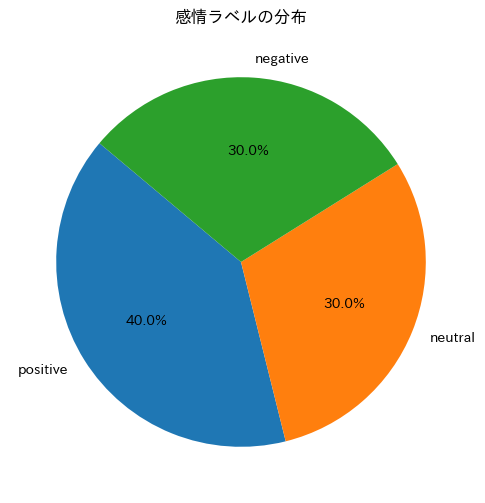

In [ ]:
# 5. 集計と可視化

## 製品ごとのレビュー件数と平均評価
review_stats = df.groupby('product_name').agg(
    review_count=('review_id', 'count'),
    avg_rating=('rating', 'mean')
).sort_values(by='review_count', ascending=False)

print("\n製品ごとのレビュー件数と平均評価:\n", review_stats)

# 感情ラベルごとの分布を円グラフで表示
sentiment_counts = df['sentiment'].value_counts()
plt.figure(figsize=(8, 6))
plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('感情ラベルの分布')
# plt.show()


分類レポート:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.00      0.00      0.00         1
           2       1.00      0.50      0.67         2

    accuracy                           0.33         3
   macro avg       0.33      0.17      0.22         3
weighted avg       0.67      0.33      0.44         3



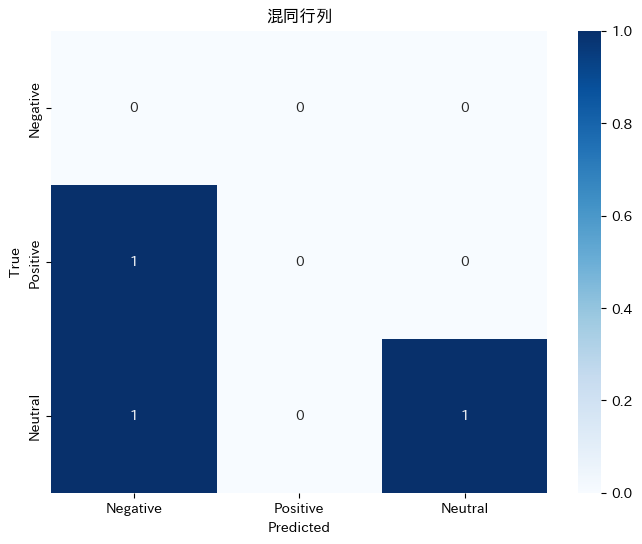

In [ ]:
from imblearn.over_sampling import RandomOverSampler


### 6. 感情分類モデルの構築

# ラベルを数値化
df['label'] = df['sentiment'].map({'positive': 1, 'negative': 0, 'neutral': 2})

# テキストのベクトル化
vectorizer = TfidfVectorizer(max_df=0.9)
X = vectorizer.fit_transform(df['processed_review'])
y = df['label']

# 学習データとテストデータの分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# ros = RandomOverSampler()
# X_resampled, y_resampled = ros.fit_resample(X, y)

# モデルの学習
model = LogisticRegression(class_weight='balanced')
model.fit(X_train, y_train)

# モデルの評価
y_pred = model.predict(X_test)

print("\n分類レポート:\n", classification_report(y_test, y_pred, zero_division=0))

# 混同行列の表示
conf_mat = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive', 'Neutral'], yticklabels=['Negative', 'Positive', 'Neutral'])
plt.title("混同行列")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()
